# Multimodal RAG using ColPali (with Byaldi) and Qwen2-VL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb)


[ColPali](https://huggingface.co/blog/manu/colpali) is a multimodal retriever that removes the need for hefty and brittle document processors. It natively handles images and processes and encodes image patches to be compatible with text, thus removing need to do OCR, or image captioning.

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

After indexing data, we will use [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to do generation part in RAG.

[Byaldi](https://github.com/AnswerDotAI/byaldi) is a new library by answer.ai to easily use ColPali. This library is in a very early stage, so this notebook will likely be updated soon with API changes.

use the right kernel for jupyter

```
pip install ipykernel
python -m ipykernel install --user --name=rag --display-name="Python (rag)"
jupyter kernelspec list
ipython
>>> import sys
>>> print(sys.executable)
```


## Install Byaldi

We will install byaldi using pip to get started.

We need to install transformers from main to get Qwen.

In [1]:
import sys
print(sys.path)

['/home/papagame/anaconda3/envs/rag/lib/python311.zip', '/home/papagame/anaconda3/envs/rag/lib/python3.11', '/home/papagame/anaconda3/envs/rag/lib/python3.11/lib-dynload', '', '/home/papagame/anaconda3/envs/rag/lib/python3.11/site-packages']


In [2]:
from huggingface_hub import notebook_login

notebook_login()

Let's see how the PDF looks like.

In [3]:
!pip show pdf2image

Name: pdf2image
Version: 1.17.0
Summary: A wrapper around the pdftoppm and pdftocairo command line tools to convert PDF to a PIL Image list.
Home-page: https://github.com/Belval/pdf2image
Author: Edouard Belval
Author-email: edouard@belval.org
License: MIT
Location: /home/papagame/anaconda3/envs/rag/lib/python3.11/site-packages
Requires: pillow
Required-by: Byaldi


In [4]:
!pip show ipywidgets

Name: ipywidgets
Version: 8.1.5
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: /home/papagame/anaconda3/envs/rag/lib/python3.11/site-packages
Requires: comm, ipython, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: 


In [5]:
!which jupyter

/home/papagame/anaconda3/envs/rag/bin/jupyter


In [11]:
from pathlib import Path
import os

In [14]:
from pdf2image import convert_from_path

file_pdf = os.path.expanduser("~/Documents/rag.pdf")
images = convert_from_path(file_pdf)

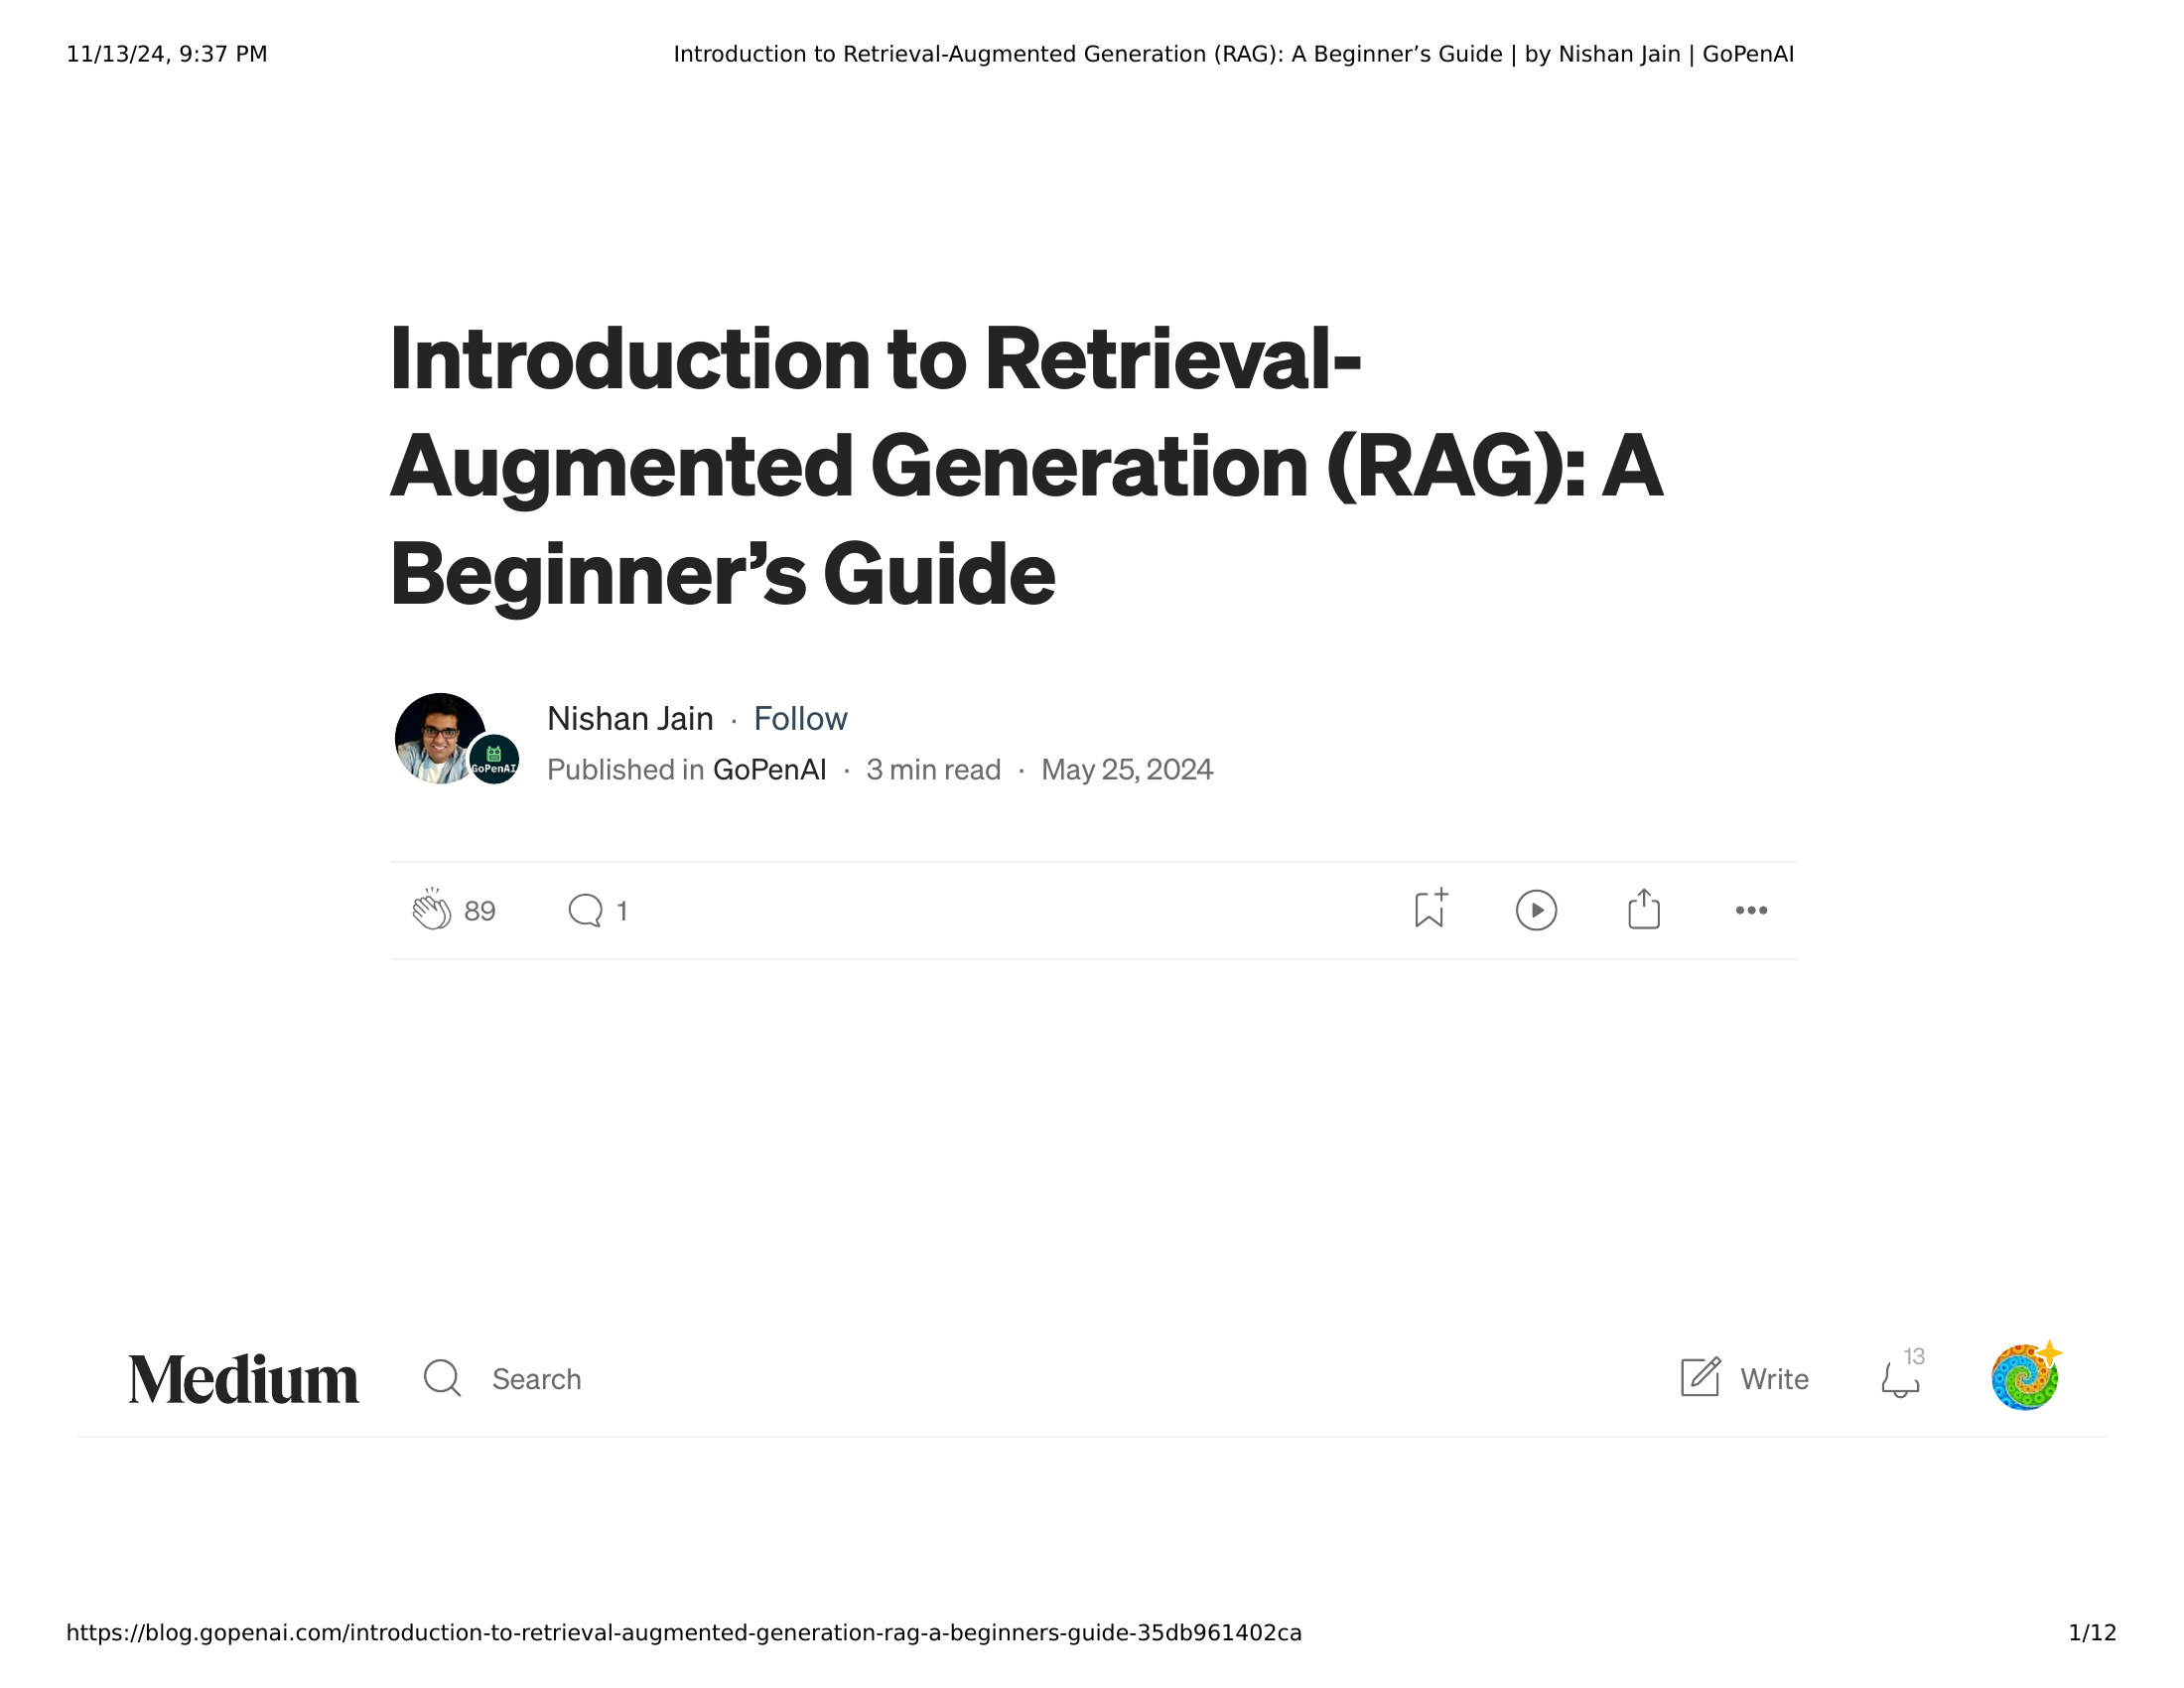

In [15]:
images[0]

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face. By default this model uses GPU but we are going to have Qwen2-VL in the same GPU so we are loading this in CPU for now.

In [16]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

KeyboardInterrupt: 

We can directly index our document using RAG, simply passing pdf file path is enough.

In [ ]:
RAG.index(
    input_path=file_pdf,
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of document 0 to index.
Added page 27 of docu

Now let's retrieve!

In [ ]:
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
results

[{'doc_id': 0, 'page_num': 6, 'score': 17.25, 'metadata': {}, 'base64': None}]

The answer was indeed on page 6, the one we accessed with `images[5]` above.

Now we can actually build a RAG pipeline. For this tutorial we will use Qwen2-VL-7B model.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [ ]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [ ]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


In [ ]:
print(output_text)

["The Earth's average global temperature has increased by around 1.1°C since the late 19th century, according to the information provided in the image."]


This is the correct answer!

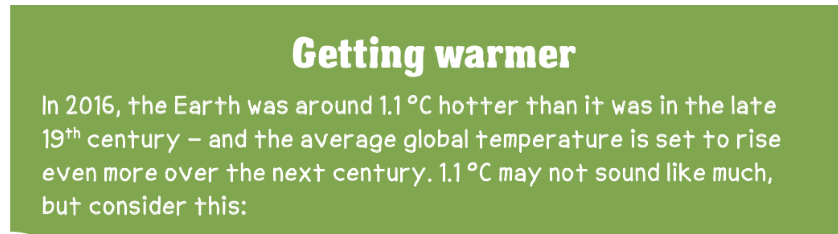